In [5]:
!pip install tab-transformer-pytorch

In [6]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import TabTransformer
import matplotlib.pyplot as plt

# 📥 Charger le dataset
df = pd.read_csv("/kaggle/input/data-set-v2/processed_dataset_preprocess_v2.csv")

# 🎯 Cible et colonnes
target = "impaye"
cat_cols = ["invoice_state", "folder_state", "is_automatic_invoicing_enabled",
            "contract_type", "civility", "first_name", "last_name", "folder_reference"]
num_cols = [col for col in df.columns if col not in cat_cols + [target]]

# 🏷️ Encodage des colonnes catégorielles
cat_dims = []
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    cat_dims.append(df[col].nunique())

# 🔢 Normalisation des colonnes numériques
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 📊 Calcul mean / std pour continuous normalization
mean = df[num_cols].mean().values
std = df[num_cols].std().replace(0, 1e-8).values
cont_mean_std = torch.tensor(np.stack([mean, std], axis=1), dtype=torch.float32)

# 🧪 Split train/test
X_train_df, X_test_df, y_train_np, y_test_np = train_test_split(df, df[target], test_size=0.2, random_state=42)
X_train_cat = torch.tensor(X_train_df[cat_cols].values, dtype=torch.long)
X_train_cont = torch.tensor(X_train_df[num_cols].values, dtype=torch.float32)
X_test_cat = torch.tensor(X_test_df[cat_cols].values, dtype=torch.long)
X_test_cont = torch.tensor(X_test_df[num_cols].values, dtype=torch.float32)
y_train = torch.tensor(y_train_np.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_np.values, dtype=torch.float32).unsqueeze(1)

# ⚙️ Préparer modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabTransformer(
    categories=tuple(cat_dims),
    num_continuous=len(num_cols),
    dim=32,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2),
    mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(TensorDataset(X_train_cat, X_train_cont, y_train), batch_size=256, shuffle=True)

# 🔁 Entraînement + Accuracy
acc_history = []
for epoch in range(100):
    model.train()
    total_loss = 0
    for x_cat, x_cont, target in train_loader:
        x_cat, x_cont, target = x_cat.to(device), x_cont.to(device), target.to(device)
        preds = model(x_cat, x_cont)
        loss = criterion(preds, target)
        if torch.isnan(loss):
            raise ValueError("🚨 Loss is NaN — check input data or learning rate.")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 📈 Évaluation à la fin de l'epoch
    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_test_cat.to(device), X_test_cont.to(device))).cpu().numpy()
        val_preds_bin = (val_preds > 0.5).astype(int)
        val_acc = accuracy_score(y_test_np.values, val_preds_bin)
        acc_history.append(val_acc)

    print(f"✅ Epoch {epoch+1} - 🎯 Accuracy: {val_acc:.4f}")




✅ Epoch 1 - 🎯 Accuracy: 0.8719
✅ Epoch 2 - 🎯 Accuracy: 0.8851
✅ Epoch 3 - 🎯 Accuracy: 0.8854
✅ Epoch 4 - 🎯 Accuracy: 0.8944
✅ Epoch 5 - 🎯 Accuracy: 0.8963
✅ Epoch 6 - 🎯 Accuracy: 0.8953
✅ Epoch 7 - 🎯 Accuracy: 0.9007
✅ Epoch 8 - 🎯 Accuracy: 0.9057
✅ Epoch 9 - 🎯 Accuracy: 0.9064
✅ Epoch 10 - 🎯 Accuracy: 0.9085
✅ Epoch 11 - 🎯 Accuracy: 0.9065
✅ Epoch 12 - 🎯 Accuracy: 0.9077
✅ Epoch 13 - 🎯 Accuracy: 0.9054
✅ Epoch 14 - 🎯 Accuracy: 0.9071
✅ Epoch 15 - 🎯 Accuracy: 0.9034
✅ Epoch 16 - 🎯 Accuracy: 0.9150
✅ Epoch 17 - 🎯 Accuracy: 0.9089
✅ Epoch 18 - 🎯 Accuracy: 0.9133
✅ Epoch 19 - 🎯 Accuracy: 0.9159
✅ Epoch 20 - 🎯 Accuracy: 0.9192
✅ Epoch 21 - 🎯 Accuracy: 0.9150
✅ Epoch 22 - 🎯 Accuracy: 0.9166
✅ Epoch 23 - 🎯 Accuracy: 0.9229
✅ Epoch 24 - 🎯 Accuracy: 0.9223
✅ Epoch 25 - 🎯 Accuracy: 0.9209
✅ Epoch 26 - 🎯 Accuracy: 0.9238
✅ Epoch 27 - 🎯 Accuracy: 0.9228
✅ Epoch 28 - 🎯 Accuracy: 0.9187
✅ Epoch 29 - 🎯 Accuracy: 0.9262
✅ Epoch 30 - 🎯 Accuracy: 0.9261
✅ Epoch 31 - 🎯 Accuracy: 0.9256
✅ Epoch 32 - 🎯 Ac

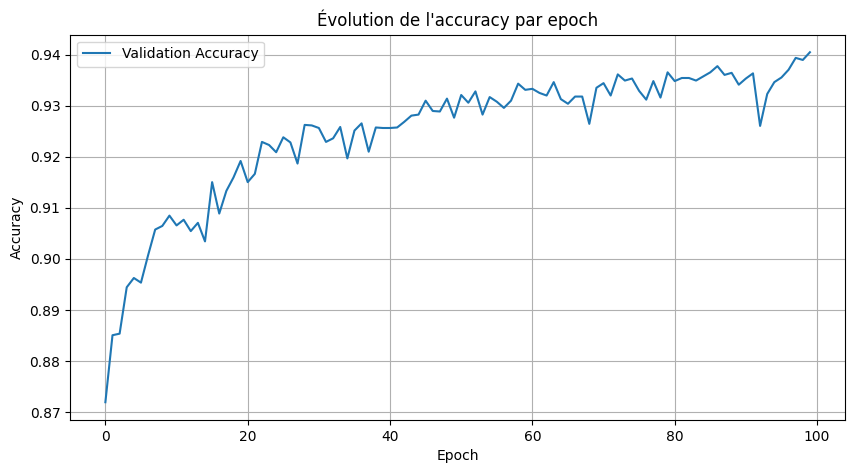

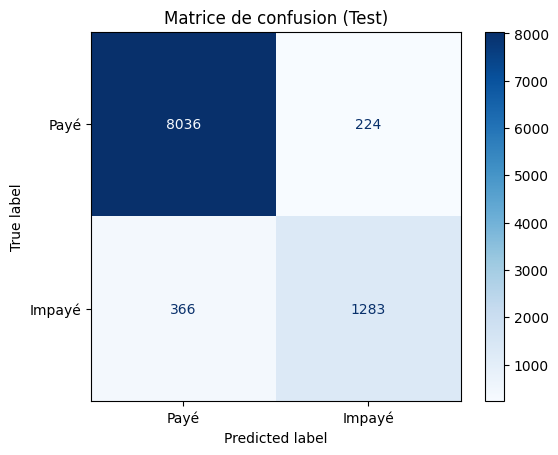

In [7]:
# 📊 Tracer l'accuracy en fonction des epochs
plt.figure(figsize=(10, 5))
plt.plot(acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Évolution de l'accuracy par epoch")
plt.grid(True)
plt.legend()
plt.show()

# 📉 Matrice de confusion finale
model.eval()
with torch.no_grad():
    final_preds = torch.sigmoid(model(X_test_cat.to(device), X_test_cont.to(device))).cpu().numpy()
    final_preds_bin = (final_preds > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_test_np.values,
    final_preds_bin,
    display_labels=["Payé", "Impayé"],
    cmap="Blues"
)
plt.title("Matrice de confusion (Test)")
plt.show()